In [1]:
import os
import shutil
import random
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, regularizers, backend as K

In [2]:
# ---------------------------
# PATH & PARAMETER
# ---------------------------
raw_data_dir = "E:\DATASET"
preprocessed_dir = "E:\Preprocessed"
split_data_dir = "E:\Split"
target_size = (224, 224)
batch_size = 32
num_classes = 4
epochs = 100

In [3]:
# ---------------------------
# 1. PREPROCESS (convert ke RGB, resize, normalisasi, save)
# ---------------------------
def preprocess_and_save(source_dir, dest_dir, target_size=(224, 224)):
    if not os.path.exists(dest_dir) or not os.listdir(dest_dir):
        for class_name in os.listdir(source_dir):
            src_path = os.path.join(source_dir, class_name)
            dst_path = os.path.join(dest_dir, class_name)
            os.makedirs(dst_path, exist_ok=True)

            for img_name in os.listdir(src_path):
                img_path = os.path.join(src_path, img_name)
                try:
                    img = Image.open(img_path).convert("RGB")  # paksa semua gambar jadi RGB
                    img = img.resize(target_size)

                    # Normalisasi piksel ke [0,1]
                    img_array = np.asarray(img).astype(np.float32) / 255.0

                    # Simpan kembali hasil normalisasi (RGB)
                    save_img = Image.fromarray((img_array * 255).astype(np.uint8))
                    save_path = os.path.join(dst_path, img_name)
                    save_img.save(save_path)
                except Exception as e:
                    print(f"Gagal memproses {img_path}: {e}")

        print(f"Preprocessing selesai dan disimpan : {dest_dir}")
    else:
        print(f"Preprocessed data sudah ada di: {dest_dir}")

In [4]:
# ---------------------------
# 2. SPLIT DATA (train/val/test)
# ---------------------------
def split_data(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if not os.path.exists(os.path.join(dest_dir, 'train')) or not os.listdir(os.path.join(dest_dir, 'train')):
        for class_name in os.listdir(source_dir):
            src_class = os.path.join(source_dir, class_name)
            images = os.listdir(src_class)
            random.shuffle(images)
            total = len(images)
            train_end = int(train_ratio * total)
            val_end = train_end + int(val_ratio * total)

            for i, img_name in enumerate(images):
                subset = "train" if i < train_end else "val" if i < val_end else "test"
                dst_path = os.path.join(dest_dir, subset, class_name)
                os.makedirs(dst_path, exist_ok=True)
                shutil.copy(os.path.join(src_class, img_name), os.path.join(dst_path, img_name))

        print(f"Data telah di-split dan disimpan di: {dest_dir}")
    else:
        print(f"Data sudah ada di folder {dest_dir}, split tidak dilakukan.")

# ---------------------------
# JALANKAN
# ---------------------------
preprocess_and_save(raw_data_dir, preprocessed_dir, target_size=(224, 224))
split_data(preprocessed_dir, split_data_dir)

Preprocessed data sudah ada di: E:\Preprocessed
Data sudah ada di folder E:\Split, split tidak dilakukan.


In [5]:
import os
from PIL import Image

def check_image_color_modes(image_dirs):
    mode_count = {'RGB': 0, 'Grayscale': 0, 'Other': 0}
    error_files = []

    # Iterate through all directories in the list
    for image_dir in image_dirs:
        print(f"Memeriksa folder: {image_dir}")
        
        # Iterate through all images in the directory
        for root, dirs, files in os.walk(image_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(root, file)

                    try:
                        # Buka gambar dengan PIL
                        with Image.open(img_path) as pil_img:
                            mode = pil_img.mode

                            if mode == 'RGB':
                                mode_count['RGB'] += 1
                            elif mode == 'L':  # Mode 'L' adalah Grayscale di PIL
                                mode_count['Grayscale'] += 1
                            else:
                                mode_count['Other'] += 1
                    except Exception as e:
                        error_files.append(f"Error loading {file}: {e}")

    # Print the results
    print("\n=== HASIL DETEKSI TIPE GAMBAR ===")
    for mode, count in mode_count.items():
        print(f"{mode}: {count} gambar")

    if error_files:
        print(f"\n❌ Gagal memproses beberapa file:")
        for error in error_files:
            print(f"- {error}")

# Ganti dengan tiga path dataset kamu
image_dirs = [
    "E:\DATASET",  # Contoh direktori, sesuaikan dengan data kamu
    "E:\Preprocessed",
    "E:\Split"
]

# Panggil fungsi untuk memeriksa mode gambar
check_image_color_modes(image_dirs)


Memeriksa folder: E:\DATASET
Memeriksa folder: E:\Preprocessed
Memeriksa folder: E:\Split

=== HASIL DETEKSI TIPE GAMBAR ===
RGB: 24861 gambar
Grayscale: 0 gambar
Other: 0 gambar


In [6]:
def check_normalized_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(root, file)
                img = Image.open(img_path).convert('RGB')
                img = img.resize((224, 224))  # Sesuai ukuran target
                img_array = np.array(img).astype(np.float32) / 255.0  # Normalisasi sementara

                if not ((img_array >= 0.0).all() and (img_array <= 1.0).all()):
                    print(f"[!] Gambar TIDAK ter-normalisasi: {img_path}")
                    return False
    print("✅ Semua gambar sudah dalam rentang normalisasi (0.0–1.0)")
    return True

# Ganti dengan direktori val dan test kamu
val_ok = check_normalized_images(os.path.join(split_data_dir, 'val'))
test_ok = check_normalized_images(os.path.join(split_data_dir, 'test'))


✅ Semua gambar sudah dalam rentang normalisasi (0.0–1.0)
✅ Semua gambar sudah dalam rentang normalisasi (0.0–1.0)


In [7]:
# ---------------------------
# 3. DATA GENERATOR (tanpa rescale)
# ---------------------------

train_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.2,
    brightness_range=[0.6, 1.4],
    channel_shift_range=30.0,
    fill_mode='nearest'
)

val_test_gen = ImageDataGenerator()  # Tidak pakai rescale

train_generator = train_gen.flow_from_directory(
    os.path.join(split_data_dir, "train"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_test_gen.flow_from_directory(
    os.path.join(split_data_dir, "val"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = val_test_gen.flow_from_directory(
    os.path.join(split_data_dir, "test"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 5800 images belonging to 4 classes.
Found 1241 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, backend as K

# ---------------------------
# BOTTLENECK RESIDUAL BLOCK
# ---------------------------
def bottleneck_block(x, filters, stride=1, downsample=False):
    shortcut = x

    # 1x1 conv (reduce)
    x = layers.Conv2D(filters, 1, strides=stride, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 3x3 conv
    x = layers.Conv2D(filters, 3, strides=1, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 1x1 conv (restore)
    x = layers.Conv2D(filters * 4, 1, strides=1, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    # Projection shortcut if needed
    if downsample or shortcut.shape[-1] != filters * 4:
        shortcut = layers.Conv2D(filters * 4, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# ---------------------------
# RESNET50 ARCHITECTURE
# ---------------------------
def build_resnet50(input_shape=(224, 224, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Conv2_x: 3 bottleneck blocks with 64 filters
    for i in range(3):
        x = bottleneck_block(x, 64, stride=1, downsample=(i == 0))

    # Conv3_x: 4 bottleneck blocks with 128 filters
    for i in range(4):
        x = bottleneck_block(x, 128, stride=2 if i == 0 else 1, downsample=(i == 0))

    # Conv4_x: 6 bottleneck blocks with 256 filters
    for i in range(6):
        x = bottleneck_block(x, 256, stride=2 if i == 0 else 1, downsample=(i == 0))

    # Conv5_x: 3 bottleneck blocks with 512 filters
    for i in range(3):
        x = bottleneck_block(x, 512, stride=2 if i == 0 else 1, downsample=(i == 0))

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# ---------------------------
# FOCAL LOSS FUNCTION
# ---------------------------
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# ---------------------------
# BUILD & COMPILE MODEL
# ---------------------------
num_classes = 4  # ganti sesuai kebutuhan
model = build_resnet50(input_shape=(224, 224, 3), num_classes=num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=focal_loss(gamma=2.0, alpha=0.25),
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     16,640 │ re_lu_2[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ add[0][0]       

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 24,585,732 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [9]:
# ---------------------------
# 5. CALLBACKS
# ---------------------------
checkpoint = ModelCheckpoint('Model Terbaik_Tahap 1_resnet50.h5', monitor='val_accuracy', save_best_only=True)
checkpoint_keras = ModelCheckpoint('Model Terbaik_Tahap 1 keras.keras', monitor='val_accuracy', save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


In [10]:
# ---------------------------
# 6. TRAINING
# ---------------------------
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[checkpoint, reduce_lr]
)

C:\Users\rayna\anaconda3\envs\tf-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2830 - loss: 1.9549

182/182 ━━━━━━━━━━━━━━━━━━━━ 896s 5s/step - accuracy: 0.2831 - loss: 1.9545 - val_accuracy: 0.2732 - val_loss: 1.8153 - learning_rate: 1.0000e-04
Epoch 2/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3700 - loss: 1.7898

182/182 ━━━━━━━━━━━━━━━━━━━━ 866s 5s/step - accuracy: 0.3700 - loss: 1.7897 - val_accuracy: 0.4118 - val_loss: 1.7566 - learning_rate: 1.0000e-04
Epoch 3/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 946s 5s/step - accuracy: 0.3735 - loss: 1.7553 - val_accuracy: 0.3602 - val_loss: 1.7321 - learning_rate: 1.0000e-04
Epoch 4/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3970 - loss: 1.7179

182/182 ━━━━━━━━━━━━━━━━━━━━ 866s 5s/step - accuracy: 0.3970 - loss: 1.7178 - val_accuracy: 0.4222 - val_loss: 1.6810 - learning_rate: 1.0000e-04
Epoch 5/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4082 - loss: 1.6739

182/182 ━━━━━━━━━━━━━━━━━━━━ 881s 5s/step - accuracy: 0.4082 - loss: 1.6738 - val_accuracy: 0.4279 - val_loss: 1.6460 - learning_rate: 1.0000e-04
Epoch 6/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 863s 5s/step - accuracy: 0.4022 - loss: 1.6308 - val_accuracy: 0.4102 - val_loss: 1.5930 - learning_rate: 1.0000e-04
Epoch 7/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4389 - loss: 1.5833

182/182 ━━━━━━━━━━━━━━━━━━━━ 867s 5s/step - accuracy: 0.4388 - loss: 1.5833 - val_accuracy: 0.4859 - val_loss: 1.5341 - learning_rate: 1.0000e-04
Epoch 8/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 890s 5s/step - accuracy: 0.4403 - loss: 1.5343 - val_accuracy: 0.3513 - val_loss: 1.5387 - learning_rate: 1.0000e-04
Epoch 9/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1017s 6s/step - accuracy: 0.4525 - loss: 1.4855 - val_accuracy: 0.4561 - val_loss: 1.4530 - learning_rate: 1.0000e-04
Epoch 10/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1054s 6s/step - accuracy: 0.4692 - loss: 1.4300 - val_accuracy: 0.3433 - val_loss: 1.4782 - learning_rate: 1.0000e-04
Epoch 11/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4975 - loss: 1.3785

182/182 ━━━━━━━━━━━━━━━━━━━━ 1041s 6s/step - accuracy: 0.4975 - loss: 1.3785 - val_accuracy: 0.5439 - val_loss: 1.3326 - learning_rate: 1.0000e-04
Epoch 12/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5210 - loss: 1.3236

182/182 ━━━━━━━━━━━━━━━━━━━━ 897s 5s/step - accuracy: 0.5210 - loss: 1.3235 - val_accuracy: 0.5584 - val_loss: 1.2719 - learning_rate: 1.0000e-04
Epoch 13/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 847s 5s/step - accuracy: 0.5616 - loss: 1.2664 - val_accuracy: 0.5117 - val_loss: 1.2437 - learning_rate: 1.0000e-04
Epoch 14/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5896 - loss: 1.2071

182/182 ━━━━━━━━━━━━━━━━━━━━ 860s 5s/step - accuracy: 0.5896 - loss: 1.2070 - val_accuracy: 0.6600 - val_loss: 1.1484 - learning_rate: 1.0000e-04
Epoch 15/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 988s 5s/step - accuracy: 0.6130 - loss: 1.1532 - val_accuracy: 0.6471 - val_loss: 1.0986 - learning_rate: 1.0000e-04
Epoch 16/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 991s 5s/step - accuracy: 0.6198 - loss: 1.1072 - val_accuracy: 0.5697 - val_loss: 1.0931 - learning_rate: 1.0000e-04
Epoch 17/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6312 - loss: 1.0557

182/182 ━━━━━━━━━━━━━━━━━━━━ 995s 5s/step - accuracy: 0.6313 - loss: 1.0556 - val_accuracy: 0.6728 - val_loss: 1.0186 - learning_rate: 1.0000e-04
Epoch 18/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6663 - loss: 1.0113

182/182 ━━━━━━━━━━━━━━━━━━━━ 987s 5s/step - accuracy: 0.6663 - loss: 1.0112 - val_accuracy: 0.6753 - val_loss: 0.9727 - learning_rate: 1.0000e-04
Epoch 19/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 989s 5s/step - accuracy: 0.6768 - loss: 0.9667 - val_accuracy: 0.6624 - val_loss: 0.9370 - learning_rate: 1.0000e-04
Epoch 20/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 988s 5s/step - accuracy: 0.6937 - loss: 0.9215 - val_accuracy: 0.6358 - val_loss: 0.9197 - learning_rate: 1.0000e-04
Epoch 21/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6989 - loss: 0.8825

182/182 ━━━━━━━━━━━━━━━━━━━━ 988s 5s/step - accuracy: 0.6989 - loss: 0.8824 - val_accuracy: 0.6914 - val_loss: 0.8717 - learning_rate: 1.0000e-04
Epoch 22/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7054 - loss: 0.8490

182/182 ━━━━━━━━━━━━━━━━━━━━ 987s 5s/step - accuracy: 0.7053 - loss: 0.8490 - val_accuracy: 0.7293 - val_loss: 0.8215 - learning_rate: 1.0000e-04
Epoch 23/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 994s 5s/step - accuracy: 0.7148 - loss: 0.8119 - val_accuracy: 0.7252 - val_loss: 0.7801 - learning_rate: 1.0000e-04
Epoch 24/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 987s 5s/step - accuracy: 0.7232 - loss: 0.7799 - val_accuracy: 0.6575 - val_loss: 0.7661 - learning_rate: 1.0000e-04
Epoch 25/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 986s 5s/step - accuracy: 0.7286 - loss: 0.7459 - val_accuracy: 0.6285 - val_loss: 0.7828 - learning_rate: 1.0000e-04
Epoch 26/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 987s 5s/step - accuracy: 0.7250 - loss: 0.7204 - val_accuracy: 0.7164 - val_loss: 0.6962 - learning_rate: 1.0000e-04
Epoch 27/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7304 - loss: 0.6866

182/182 ━━━━━━━━━━━━━━━━━━━━ 988s 5s/step - accuracy: 0.7304 - loss: 0.6865 - val_accuracy: 0.7421 - val_loss: 0.6737 - learning_rate: 1.0000e-04
Epoch 28/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 985s 5s/step - accuracy: 0.7477 - loss: 0.6596 - val_accuracy: 0.6865 - val_loss: 0.6584 - learning_rate: 1.0000e-04
Epoch 29/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 985s 5s/step - accuracy: 0.7401 - loss: 0.6412 - val_accuracy: 0.7139 - val_loss: 0.6185 - learning_rate: 1.0000e-04
Epoch 30/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 994s 5s/step - accuracy: 0.7588 - loss: 0.6132 - val_accuracy: 0.6084 - val_loss: 0.6328 - learning_rate: 1.0000e-04
Epoch 31/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 994s 5s/step - accuracy: 0.7629 - loss: 0.5918 - val_accuracy: 0.6608 - val_loss: 0.6249 - learning_rate: 1.0000e-04
Epoch 32/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 991s 5s/step - accuracy: 0.7468 - loss: 0.5741 - val_accuracy: 0.6261 - val_loss: 0.6290 - learning_rate: 1.0000e-04
Epoch 33/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accu

182/182 ━━━━━━━━━━━━━━━━━━━━ 986s 5s/step - accuracy: 0.7736 - loss: 0.5517 - val_accuracy: 0.7808 - val_loss: 0.5363 - learning_rate: 1.0000e-04
Epoch 34/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 990s 5s/step - accuracy: 0.7605 - loss: 0.5370 - val_accuracy: 0.7599 - val_loss: 0.5259 - learning_rate: 1.0000e-04
Epoch 35/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 991s 5s/step - accuracy: 0.7738 - loss: 0.5163 - val_accuracy: 0.5294 - val_loss: 0.6795 - learning_rate: 1.0000e-04
Epoch 36/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 992s 5s/step - accuracy: 0.7626 - loss: 0.5028 - val_accuracy: 0.5761 - val_loss: 0.5741 - learning_rate: 1.0000e-04
Epoch 37/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 990s 5s/step - accuracy: 0.7673 - loss: 0.4870 - val_accuracy: 0.7059 - val_loss: 0.4906 - learning_rate: 1.0000e-04
Epoch 38/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 991s 5s/step - accuracy: 0.7685 - loss: 0.4705 - val_accuracy: 0.7478 - val_loss: 0.4742 - learning_rate: 1.0000e-04
Epoch 39/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 990s 5s/step - ac

182/182 ━━━━━━━━━━━━━━━━━━━━ 994s 5s/step - accuracy: 0.7878 - loss: 0.4413 - val_accuracy: 0.8026 - val_loss: 0.4317 - learning_rate: 1.0000e-04
Epoch 41/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 994s 5s/step - accuracy: 0.7755 - loss: 0.4317 - val_accuracy: 0.7486 - val_loss: 0.4255 - learning_rate: 1.0000e-04
Epoch 42/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 992s 5s/step - accuracy: 0.7893 - loss: 0.4200 - val_accuracy: 0.7953 - val_loss: 0.4046 - learning_rate: 1.0000e-04
Epoch 43/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 983s 5s/step - accuracy: 0.7848 - loss: 0.4076 - val_accuracy: 0.7486 - val_loss: 0.4114 - learning_rate: 1.0000e-04
Epoch 44/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 984s 5s/step - accuracy: 0.7958 - loss: 0.3973 - val_accuracy: 0.7873 - val_loss: 0.3896 - learning_rate: 1.0000e-04
Epoch 45/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 964s 5s/step - accuracy: 0.7980 - loss: 0.3848 - val_accuracy: 0.4561 - val_loss: 0.5919 - learning_rate: 1.0000e-04
Epoch 46/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1062s 6s/step - a

182/182 ━━━━━━━━━━━━━━━━━━━━ 1162s 6s/step - accuracy: 0.7997 - loss: 0.3694 - val_accuracy: 0.8316 - val_loss: 0.3469 - learning_rate: 1.0000e-04
Epoch 48/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1152s 6s/step - accuracy: 0.8017 - loss: 0.3579 - val_accuracy: 0.7542 - val_loss: 0.3731 - learning_rate: 1.0000e-04
Epoch 49/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1155s 6s/step - accuracy: 0.7954 - loss: 0.3516 - val_accuracy: 0.6664 - val_loss: 0.3831 - learning_rate: 1.0000e-04
Epoch 50/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1024s 6s/step - accuracy: 0.8106 - loss: 0.3383 - val_accuracy: 0.8090 - val_loss: 0.3341 - learning_rate: 1.0000e-04
Epoch 51/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 863s 5s/step - accuracy: 0.7997 - loss: 0.3351 - val_accuracy: 0.7663 - val_loss: 0.3329 - learning_rate: 1.0000e-04
Epoch 52/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 852s 5s/step - accuracy: 0.7965 - loss: 0.3267 - val_accuracy: 0.7663 - val_loss: 0.3381 - learning_rate: 1.0000e-04
Epoch 53/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 863s 5s/step 

182/182 ━━━━━━━━━━━━━━━━━━━━ 995s 5s/step - accuracy: 0.8196 - loss: 0.2641 - val_accuracy: 0.8340 - val_loss: 0.2570 - learning_rate: 1.0000e-04
Epoch 63/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 996s 5s/step - accuracy: 0.8220 - loss: 0.2611 - val_accuracy: 0.8010 - val_loss: 0.2693 - learning_rate: 1.0000e-04
Epoch 64/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 993s 5s/step - accuracy: 0.8372 - loss: 0.2536 - val_accuracy: 0.7260 - val_loss: 0.2866 - learning_rate: 1.0000e-04
Epoch 65/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 992s 5s/step - accuracy: 0.8396 - loss: 0.2480 - val_accuracy: 0.7373 - val_loss: 0.2951 - learning_rate: 1.0000e-04
Epoch 66/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8315 - loss: 0.2465

182/182 ━━━━━━━━━━━━━━━━━━━━ 994s 5s/step - accuracy: 0.8315 - loss: 0.2465 - val_accuracy: 0.8453 - val_loss: 0.2398 - learning_rate: 1.0000e-04
Epoch 67/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1001s 5s/step - accuracy: 0.8484 - loss: 0.2397 - val_accuracy: 0.8413 - val_loss: 0.2374 - learning_rate: 1.0000e-04
Epoch 68/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 995s 5s/step - accuracy: 0.8309 - loss: 0.2401 - val_accuracy: 0.7977 - val_loss: 0.2471 - learning_rate: 1.0000e-04
Epoch 69/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 992s 5s/step - accuracy: 0.8470 - loss: 0.2304 - val_accuracy: 0.7728 - val_loss: 0.2476 - learning_rate: 1.0000e-04
Epoch 70/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 994s 5s/step - accuracy: 0.8435 - loss: 0.2304 - val_accuracy: 0.8388 - val_loss: 0.2315 - learning_rate: 1.0000e-04
Epoch 71/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 992s 5s/step - accuracy: 0.8383 - loss: 0.2273 - val_accuracy: 0.8445 - val_loss: 0.2263 - learning_rate: 1.0000e-04
Epoch 72/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 995s 5s/step - a

182/182 ━━━━━━━━━━━━━━━━━━━━ 907s 5s/step - accuracy: 0.8468 - loss: 0.2013 - val_accuracy: 0.8517 - val_loss: 0.2019 - learning_rate: 1.0000e-04
Epoch 80/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1025s 6s/step - accuracy: 0.8575 - loss: 0.1948 - val_accuracy: 0.8002 - val_loss: 0.2106 - learning_rate: 1.0000e-04
Epoch 81/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 859s 5s/step - accuracy: 0.8507 - loss: 0.1946 - val_accuracy: 0.7712 - val_loss: 0.2312 - learning_rate: 1.0000e-04
Epoch 82/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 879s 5s/step - accuracy: 0.8517 - loss: 0.1928 - val_accuracy: 0.7945 - val_loss: 0.2235 - learning_rate: 1.0000e-04
Epoch 83/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 992s 5s/step - accuracy: 0.8439 - loss: 0.1916 - val_accuracy: 0.8171 - val_loss: 0.2096 - learning_rate: 1.0000e-04
Epoch 84/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1010s 6s/step - accuracy: 0.8644 - loss: 0.1833 - val_accuracy: 0.7808 - val_loss: 0.2111 - learning_rate: 1.0000e-04
Epoch 85/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - ac

182/182 ━━━━━━━━━━━━━━━━━━━━ 1004s 6s/step - accuracy: 0.8827 - loss: 0.1770 - val_accuracy: 0.8598 - val_loss: 0.1845 - learning_rate: 5.0000e-05
Epoch 86/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8791 - loss: 0.1745

182/182 ━━━━━━━━━━━━━━━━━━━━ 997s 5s/step - accuracy: 0.8791 - loss: 0.1745 - val_accuracy: 0.8920 - val_loss: 0.1771 - learning_rate: 5.0000e-05
Epoch 87/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1003s 6s/step - accuracy: 0.8838 - loss: 0.1711 - val_accuracy: 0.8421 - val_loss: 0.1848 - learning_rate: 5.0000e-05
Epoch 88/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1016s 6s/step - accuracy: 0.8938 - loss: 0.1690 - val_accuracy: 0.8606 - val_loss: 0.1811 - learning_rate: 5.0000e-05
Epoch 89/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 999s 5s/step - accuracy: 0.8944 - loss: 0.1661 - val_accuracy: 0.7969 - val_loss: 0.1929 - learning_rate: 5.0000e-05
Epoch 90/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 996s 5s/step - accuracy: 0.8838 - loss: 0.1664 - val_accuracy: 0.8018 - val_loss: 0.1922 - learning_rate: 5.0000e-05
Epoch 91/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 997s 5s/step - accuracy: 0.8834 - loss: 0.1654 - val_accuracy: 0.8735 - val_loss: 0.1748 - learning_rate: 5.0000e-05
Epoch 92/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 997s 5s/step - 

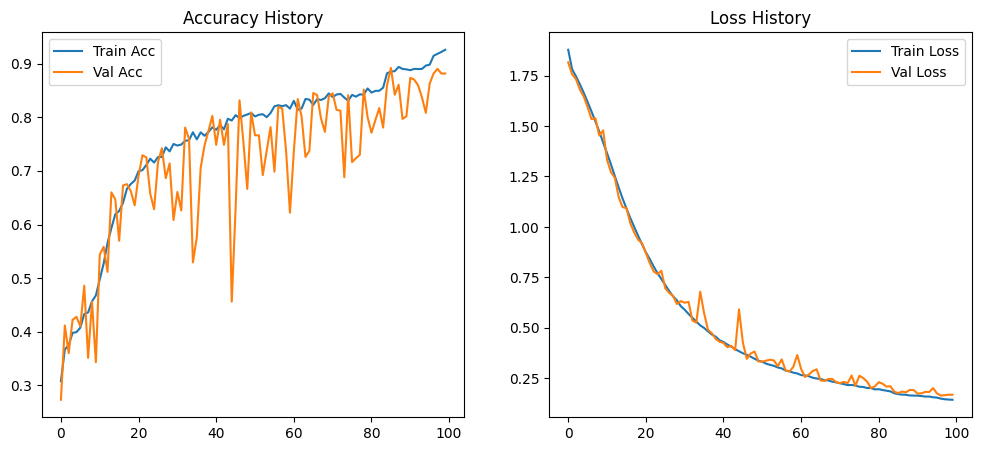

In [11]:
# ---------------------------
# 7. PLOT TRAINING
# ---------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy History')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss History')
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 928ms/step
Classification Report:
                   precision    recall  f1-score   support

Asiatic-Mongoloid       0.89      0.95      0.92       301
  Kaukasoid-Indic       0.82      0.82      0.82       333
Malayan-Mongoloid       0.88      0.78      0.83       304
       Melanesoid       0.89      0.92      0.91       308

         accuracy                           0.87      1246
        macro avg       0.87      0.87      0.87      1246
     weighted avg       0.87      0.87      0.87      1246



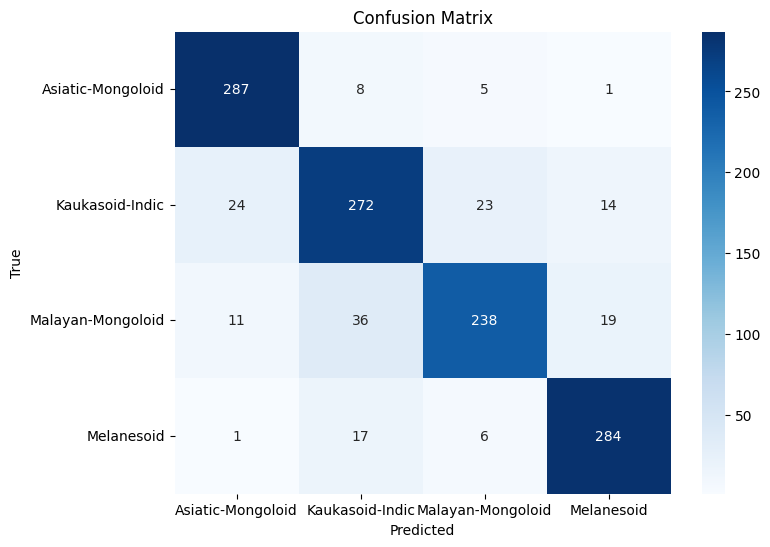

In [12]:
# ---------------------------
# 8. EVALUASI MODEL
# ---------------------------
y_true = test_generator.classes
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)

labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 317ms/step
Classification Report:
                   precision    recall  f1-score   support

Asiatic-Mongoloid       0.95      0.96      0.95       301
  Kaukasoid-Indic       0.83      0.86      0.84       333
Malayan-Mongoloid       0.83      0.84      0.83       304
       Melanesoid       0.95      0.89      0.92       308

         accuracy                           0.89      1246
        macro avg       0.89      0.89      0.89      1246
     weighted avg       0.89      0.89      0.89      1246



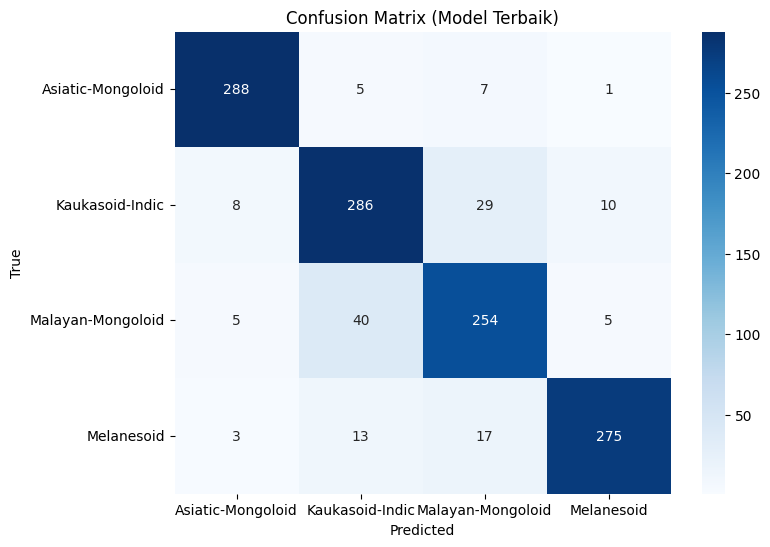

In [13]:
from tensorflow.keras.models import load_model

best_model = load_model(r"E:\Model Terbaik_Tahap 1.h5", custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)})


# 2. Prediksi pakai model terbaik
y_true = test_generator.classes
y_prob = best_model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)

# 3. Buat label
labels = list(test_generator.class_indices.keys())

# 4. Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# 5. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Model Terbaik)")
plt.show()


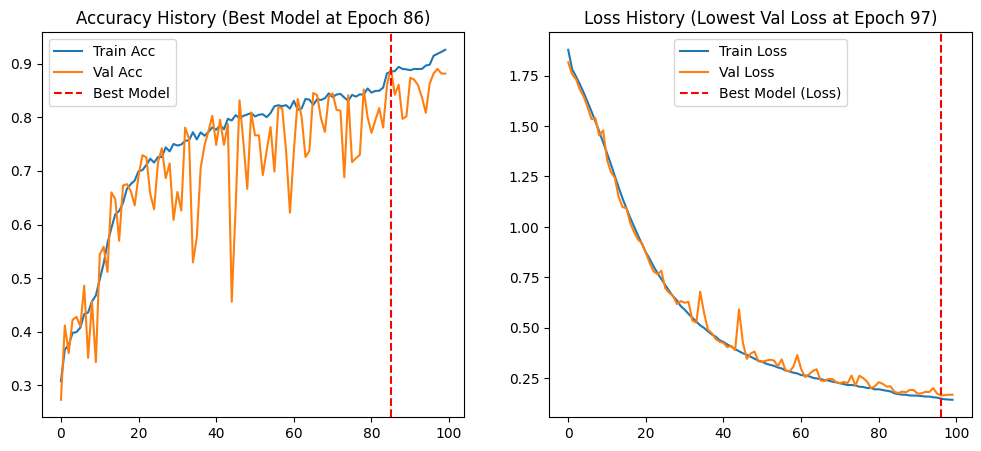

In [15]:
# ---------------------------
# 7. PLOT TRAINING (MODEL TERBAIK)
# ---------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.axvline(x=np.argmax(history.history['val_accuracy']), color='r', linestyle='--', label='Best Model')
plt.legend()
plt.title('Accuracy History (Best Model at Epoch {})'.format(np.argmax(history.history['val_accuracy']) + 1))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axvline(x=np.argmin(history.history['val_loss']), color='r', linestyle='--', label='Best Model (Loss)')
plt.legend()
plt.title('Loss History (Lowest Val Loss at Epoch {})'.format(np.argmin(history.history['val_loss']) + 1))

plt.show()


39/39 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step
Classification Report:
                   precision    recall  f1-score   support

Asiatic-Mongoloid       0.91      0.94      0.93       301
  Kaukasoid-Indic       0.83      0.83      0.83       333
Malayan-Mongoloid       0.85      0.77      0.81       304
       Melanesoid       0.88      0.94      0.91       308

         accuracy                           0.87      1246
        macro avg       0.87      0.87      0.87      1246
     weighted avg       0.87      0.87      0.87      1246



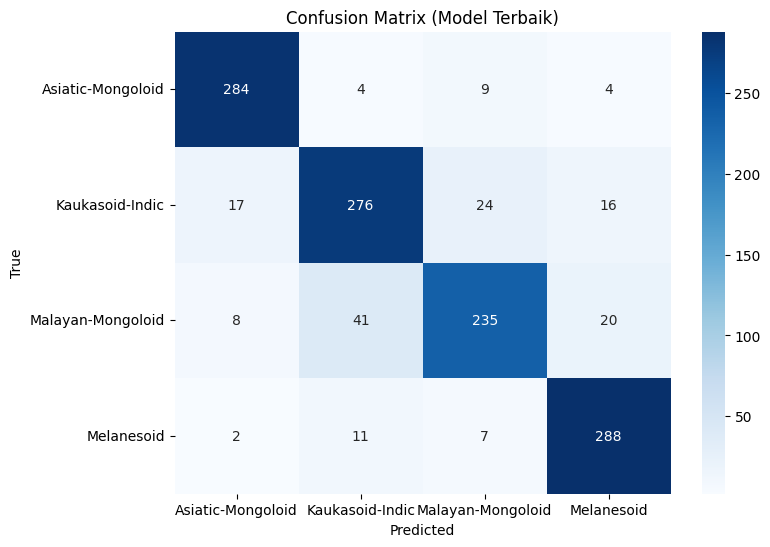

In [16]:
from tensorflow.keras.models import load_model

best_model = load_model(r"C:\Users\rayna\Downloads\Model Terbaik_Tahap 1_resnet50.h5", custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)})


# 2. Prediksi pakai model terbaik
y_true = test_generator.classes
y_prob = best_model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)

# 3. Buat label
labels = list(test_generator.class_indices.keys())

# 4. Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# 5. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Model Terbaik)")
plt.show()


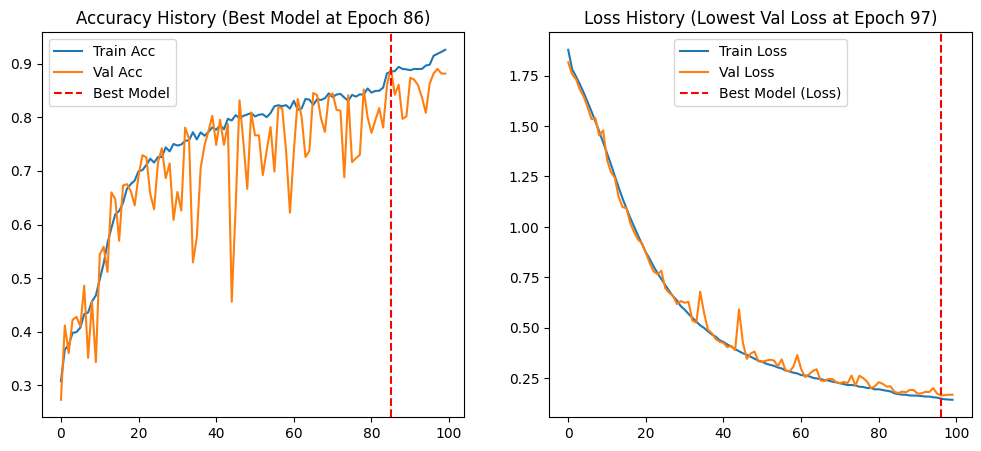

In [18]:
# ---------------------------
# 7. PLOT TRAINING (MODEL TERBAIK)
# ---------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.axvline(x=np.argmax(history.history['val_accuracy']), color='r', linestyle='--', label='Best Model')
plt.legend()
plt.title('Accuracy History (Best Model at Epoch {})'.format(np.argmax(history.history['val_accuracy']) + 1))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axvline(x=np.argmin(history.history['val_loss']), color='r', linestyle='--', label='Best Model (Loss)')
plt.legend()
plt.title('Loss History (Lowest Val Loss at Epoch {})'.format(np.argmin(history.history['val_loss']) + 1))

plt.show()
